In [ ]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
import keras
import time
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

In [ ]:
%%capture
!wget -O Medical_train.zip https://www.dropbox.com/scl/fi/x6hifnqqkuq1p33vr109s/Medical_train.zip?rlkey=vr1ob1xmj5bkfa2r21ef5uwnd&dl=0
!wget -O Medical_test.zip https://www.dropbox.com/scl/fi/8n9q6au9qcnpiwtwtojkm/Medical_test.zip?rlkey=j42oncxl79hp0uvgz3gz66ev4&dl=0
!wget -O Medical_val.zip https://www.dropbox.com/scl/fi/a17q72jelw3j7svdhsuiq/Medical_val.zip?rlkey=jo2bagqzwvq7uol2hw5lpjzmz&dl=0

In [ ]:
zip_train = ZipFile('Medical_train.zip')
zip_train.extractall()
zip_val = ZipFile('Medical_val.zip')
zip_val.extractall()
zip_test = ZipFile('Medical_test.zip')
zip_test.extractall()

In [ ]:
data_dir = '/content/'
train_path = '/content/Medical_train'
val_path = '/content/Medical_val'

height = 30
width = 30
channels = 1

In [ ]:
data = []
labels = []
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

6

In [ ]:
LIST_CATEGORIES=os.listdir('/content/Medical_train/')
print(LIST_CATEGORIES)

['Hand', 'BreastMRI', 'ChestCT', 'AbdomenCT', 'CXR', 'HeadCT']


In [ ]:
def image_converter(data_path):
    label_encoder = LabelEncoder()
    new_image = []
    new_labels = []
    for folder_name in LIST_CATEGORIES:
        path = os.path.join(data_path, folder_name)
        images = os.listdir(path)
        for a in images:
            image = Image.open(path + '/' + a)  # Конвертируем изображение в черно-белое
            image = image.resize((height, width))
            image = np.array(image)
            new_image.append(image)
            new_labels.append(folder_name)
    new_image = np.array(new_image)
    new_image = np.expand_dims(new_image, axis=-1)
    new_image = new_image / 255.0

    new_labels = np.array(new_labels)
    new_labels = label_encoder.fit_transform(new_labels)
    NUM_CATEGORIES = len(np.unique(new_labels))
    new_labels = to_categorical(new_labels, NUM_CATEGORIES)
    return new_image, new_labels

train_data, train_labels = image_converter('/content/Medical_train')
val_data, val_labels = image_converter('/content/Medical_val')
test_data, test_labels = image_converter('/content/Medical_test')

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(height,width,1)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(NUM_CATEGORIES, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 9, 9, 64)          36928     
                                                      

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [ ]:
batch_size = 32
epochs = 8

history = model.fit(aug.flow(train_data,train_labels,batch_size=batch_size),
                    epochs=epochs, validation_data=(val_data, val_labels) )

Epoch 1/8
1474/1474 [==============================] - 151s 101ms/step - loss: 0.1174 - accuracy: 0.9602 - val_loss: 0.0148 - val_accuracy: 0.9978
Epoch 2/8
1474/1474 [==============================] - 145s 99ms/step - loss: 0.0235 - accuracy: 0.9926 - val_loss: 0.0056 - val_accuracy: 0.9985
Epoch 3/8
1474/1474 [==============================] - 145s 98ms/step - loss: 0.0309 - accuracy: 0.9906 - val_loss: 0.0061 - val_accuracy: 0.9981
Epoch 4/8
1474/1474 [==============================] - 144s 97ms/step - loss: 0.0194 - accuracy: 0.9940 - val_loss: 0.0026 - val_accuracy: 0.9997
Epoch 5/8
1474/1474 [==============================] - 142s 97ms/step - loss: 0.0257 - accuracy: 0.9924 - val_loss: 0.0146 - val_accuracy: 0.9953
Epoch 6/8
1474/1474 [==============================] - 145s 98ms/step - loss: 0.0181 - accuracy: 0.9945 - val_loss: 8.5241e-04 - val_accuracy: 0.9997
Epoch 7/8
1474/1474 [==============================] - 141s 95ms/step - loss: 0.0137 - accuracy: 0.9963 - val_loss: 0.0

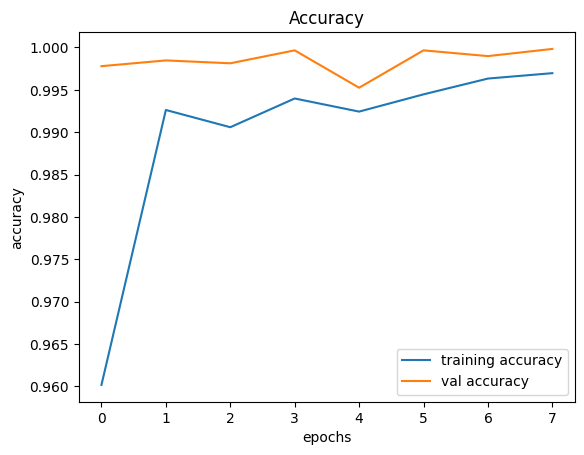

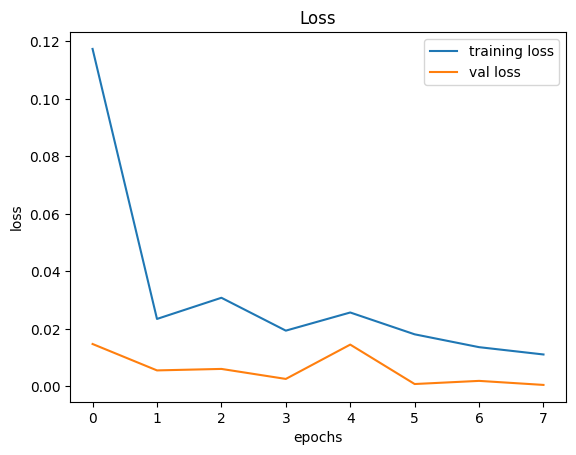

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
start_time = time.time()
predict = model.predict(test_data)
end_time = time.time()

predict = np.argmax(predict, axis=1)
print(f"Time taken for prediction: {end_time - start_time} seconds")

185/185 [==============================] - 4s 21ms/step
Time taken for prediction: 5.565221786499023 seconds


In [ ]:
from sklearn.metrics import accuracy_score
test_argmax = np.argmax(test_labels, axis=1)
print('Test Data accuracy: ', accuracy_score(test_argmax, predict)*100)

Test Data accuracy:  99.91519674355496
